# Continue with the Churn Prediction.

### K-Nearest Neighbours (KNN), Random Forest, Gradient Boosting, AdaBoost, Naive Bayes and Logistic regression models.
    

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.ensemble import RandomForestClassifier,\
GradientBoostingClassifier,AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, FeatureUnion
import warnings
warnings.filterwarnings('ignore')
from sklearn.base import BaseEstimator, TransformerMixin

class OneHotEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self,col):
        self.col = col
                
    def transform(self, X):
        return pd.get_dummies(X[self.col]) 

    def fit(self, X, y=None):
        return self  
    
# Stateless transformer for selecting a specified columns
class DFSubsetSelector(BaseEstimator,TransformerMixin):
    
    def __init__(self,cols):
        self.cols = cols
        
    def transform(self ,X):
        return X[self.cols]
    
    def fit(self, X, y=None):
        return self
    
class ConcatFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self,cols,sep="_"):
        self.cols = cols
        self.sep = sep
                
    def transform(self, X):
        concat_col = self.sep.join(self.cols)
        return X.apply(lambda x : self.sep.join([x[col] for col in self.cols]) ,axis=1).to_frame(name = concat_col)

    def fit(self, X, y=None):
        return self  
    
# Transformer that does min-max transform on the specified columns
class MinMaxTransform(BaseEstimator, TransformerMixin):

    def __init__(self,cols=None):
        self.cols = cols
        self.minVec = np.zeros(len(cols))
        self.maxVec = np.zeros(len(cols))
       
    def transform(self, X):
        X[self.cols] = ((X[self.cols] - self.minVec)/(self.maxVec-self.minVec))
        return X

    def fit(self, X, y=None):
        self.minVec = (df_train[self.cols].min())
        self.maxVec = (df_train[self.cols].max())
        return self

df = pd.read_csv('hw5.csv', delimiter=',')

#DONOT CHANGE THIS
df_train = df.sample(frac=0.8,random_state=11)
df_val = df.drop(df_train.index)


X_train = df_train.drop(['Exited'],axis=1)
y_train = df_train['Exited']
X_val= df_val.drop(['Exited'],axis=1)
y_val = df_val['Exited']

continuous_vars = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']
cat_vars = ['HasCrCard','IsActiveMember',"Geography", "Gender"] 

#building the data-processing pipeline
categorical_feature_pipeline = Pipeline([
                                       ('categorical_selector' ,DFSubsetSelector(cat_vars)),
                                        ('onehot',OneHotEncoder(cat_vars))])
numerical_feature_pipeline = Pipeline([
                                       ('numerical_selector' ,DFSubsetSelector(continuous_vars)),
                                        ('normalization',MinMaxTransform(continuous_vars))])
all_feature_preprocessor= FeatureUnion(transformer_list=[('numerical_preprocessor', numerical_feature_pipeline),
                                                      ('categorical_preprocessor', categorical_feature_pipeline)])

In [22]:
k_list = np.arange(49)+2
val_list = []
train_list = []
for k in k_list:
    classifier = Pipeline(steps = [('preprocessor', all_feature_preprocessor),
                             ('classifier',knn(n_neighbors=k))])
    classifier.fit(X_train,y_train)
    prob_val = classifier.predict_proba(X_val)[:,1]
    prob_train = classifier.predict_proba(X_train)[:,1]
    auroc_val = roc_auc_score(y_val,prob_val)
    auroc_train = roc_auc_score(y_train,prob_train)
    val_list.append(auroc_val)
    train_list.append(auroc_train)


The Best Validation AUROC is 0.8205577703831526 and uses k = 18


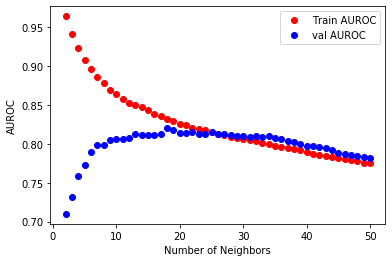

In [85]:
import operator
fig,ax = plt.subplots()
ax.plot(k_list,train_list,'ro',label='Train AUROC')
ax.plot(k_list,val_list,'bo',label='val AUROC')
plt.xlabel('Number of Neighbors')
plt.ylabel('AUROC')
ax.legend()
max_auroc_val = max(val_list)
max_k = val_list.index(max(val_list))+2
print ('The Best Validation AUROC is {} and uses k = {}' .format (max_auroc_val,max_k))

In [36]:
#KNN
clf1 = Pipeline(steps = [('preprocessor', all_feature_preprocessor),
                             ('classifier',knn(n_neighbors=max_k))])
clf1.fit(X_train,y_train)
clf1_pred = clf1.predict(X_val)
clf1_f1 = round(f1_score(y_val,clf1_pred),6)
clf1_probas = clf1.predict_proba(X_val)[:,1]
clf1_rocaucscore = round(roc_auc_score(y_val,clf1_probas),6)
# print('KNN F1 Score:',clf1_f1)
# print('KNN auroc Score:',clf1_rocaucscore)

#Naive Bayes
clf2 = Pipeline(steps = [('preprocessor', all_feature_preprocessor),
                             ('classifier',GaussianNB())])
clf2.fit(X_train,y_train)
clf2_pred = clf2.predict(X_val)
clf2_f1 = round(f1_score(y_val,clf2_pred),6)
clf2_probas = clf2.predict_proba(X_val)[:,1]
clf2_rocaucscore = round(roc_auc_score(y_val,clf2_probas),6)
# print('Naive Bayes F1 Score:',clf2_f1)
# print('Naive Bayes auroc Score:',clf2_rocaucscore)

#Logistic Regression
clf3 = Pipeline(steps = [('preprocessor', all_feature_preprocessor),
                             ('classifier',LogisticRegression(class_weight='balanced'))])
clf3.fit(X_train,y_train)
clf3_pred = clf3.predict(X_val)
clf3_f1 = round(f1_score(y_val,clf3_pred),6)
clf3_probas = clf3.predict_proba(X_val)[:,1]
clf3_rocaucscore = round(roc_auc_score(y_val,clf3_probas),6)
# print('Logistic Regression F1 Score:',clf3_f1)
# print('Logistic Regression auroc Score:',clf3_rocaucscore)

#Ensamble ny averaging posterior probabilities
eclf1 = VotingClassifier(
     estimators=[('KNN', clf1), ('Naive Bayes', clf2), ('Logistic Regression', clf3)],
     voting='soft')
eclf1.fit(X_train,y_train)
eclf1_pred = eclf1.predict(X_val)
eclf1_f1 = round(f1_score(y_val,eclf1_pred),6)
eclf1_probas = eclf1.predict_proba(X_val)[:,1]
eclf1_rocaucscore = round(roc_auc_score(y_val,eclf1_probas),6)
print('Ensamble With Soft Vote F1 Score:',eclf1_f1)
print('Ensamble With Soft Vote auroc Score:',eclf1_rocaucscore)

#Ensamble With Majority Voting
eclf2 = VotingClassifier(
     estimators=[('KNN', clf1), ('Naive Bayes', clf2), ('Logistic Regression', clf3)],
     voting='hard')
eclf2.fit(X_train,y_train)
eclf2_pred = eclf2.predict(X_val)
eclf2_f1 = round(f1_score(y_val,eclf2_pred),6)
print('Ensamble With Majority Vote F1 Score:',eclf2_f1)


Ensamble With Soft Vote F1 Score: 0.523529
Ensamble With Soft Vote auroc Score: 0.840481
Ensamble With Majority Vote F1 Score: 0.486647


To enable threshold variations you need real outputs. In hard voting there is not real ouputs. If you average the outputs from each network (soft voting) rather than using majority voting (hard voting) you can get the ROC.

In [42]:
X_train2 = all_feature_preprocessor.fit_transform(X_train)
X_val2 = all_feature_preprocessor.fit_transform(X_val)


In [73]:
param_grid = {
    'n_estimators' : [400,500,600,700],
    'max_features' : ['sqrt','log2','auto'],
    'criterion' : ['gini','entropy']
} 
rf_grid = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid,cv=2)
rf_grid.fit(X_train2, y_train)
rf_grid.best_params_

{'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 400}

THIS IS THE CONFUSION MATRIX BELOW

[[ 206  207]
 [  49 1538]]


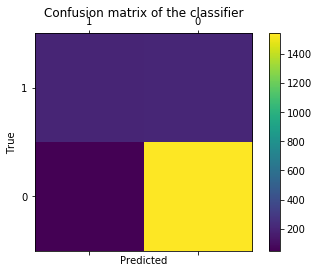

In [74]:
# Confusion matrix for gradient boosting
rf = RandomForestClassifier(n_estimators = 400 ,max_features = 'sqrt',criterion = 'entropy')
rf.fit(X_train2,y_train)
y_pred = rf.predict(X_val2)

print("THIS IS THE CONFUSION MATRIX BELOW")
print("")
labels = [1, 0]
cm = confusion_matrix(y_val, y_pred, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [75]:
#Find AUROC for gradient boosting
prob_rf = rf.predict_proba(X_val2)[:,1]
auroc = roc_auc_score(y_val,prob_rf)
print('Random Forest AUROC score =', auroc)

Random Forest AUROC score = 0.8849634820446393


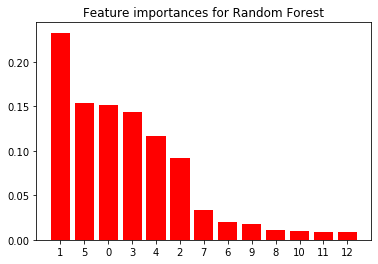

1. feature 1 (0.232934)
2. feature 5 (0.153876)
3. feature 0 (0.151601)
4. feature 3 (0.144152)
5. feature 4 (0.116493)
6. feature 2 (0.091509)
7. feature 7 (0.033766)
8. feature 6 (0.019601)
9. feature 9 (0.017799)
10. feature 8 (0.010600)
11. feature 10 (0.009491)
12. feature 11 (0.009221)
13. feature 12 (0.008956)


In [82]:
# Plot the Feature importance for random forest
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances for Random Forest")
plt.bar(range(X_train2.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X_train2.shape[1]), indices)
plt.xlim([-1, X_train2.shape[1]])
plt.show()

for f in range(X_train2.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

In [47]:
param_grid = {
    'n_estimators' : [70,80,90,100],
    'learning_rate' : [0.1,0.15,0.2],
    'max_depth' : [2,3,4,5]
} 
boost_grid = GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid,cv=2)
boost_grid.fit(X_train2, y_train)
boost_grid.best_params_

{'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 90}

THIS IS THE CONFUSION MATRIX BELOW

[[ 204  209]
 [  55 1532]]


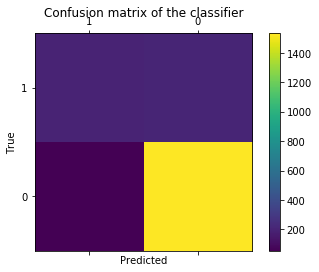

In [61]:
# Confusion matrix for gradient boosting
boost = GradientBoostingClassifier(max_depth = 2, n_estimators = 90,learning_rate = 0.15)
boost.fit(X_train2,y_train)
y_pred = boost.predict(X_val2)

from sklearn.metrics import confusion_matrix

print("THIS IS THE CONFUSION MATRIX BELOW")
print("")
labels = [1, 0]
cm = confusion_matrix(y_val, y_pred, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [53]:
#Find AUROC for gradient boosting
prob_boost = boost.predict_proba(X_val2)[:,1]
auroc = roc_auc_score(y_val,prob_boost)
print('Gradient Boosting AUROC score =', auroc)

Gradient Boosting AUROC score = 0.8902699139955235


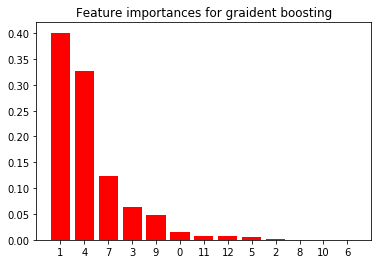

1. feature 1 (0.400910)
2. feature 4 (0.327650)
3. feature 7 (0.122606)
4. feature 3 (0.063895)
5. feature 9 (0.047496)
6. feature 0 (0.015685)
7. feature 11 (0.007694)
8. feature 12 (0.007518)
9. feature 5 (0.005181)
10. feature 2 (0.000961)
11. feature 8 (0.000404)
12. feature 10 (0.000000)
13. feature 6 (0.000000)


In [83]:
# Plot the Feature importance for graident boosting
importances = boost.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances for graident boosting")
plt.bar(range(X_train2.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X_train2.shape[1]), indices)
plt.xlim([-1, X_train2.shape[1]])
plt.show()

for f in range(X_train2.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

In [57]:
param_grid = {
    'n_estimators' : [225,250,265,275],
    'learning_rate' : [0.25,0.3,0.35,0.4]
} 
adaboost_grid = GridSearchCV(estimator = AdaBoostClassifier(), param_grid = param_grid,cv=2)
adaboost_grid.fit(X_train2, y_train)
adaboost_grid.best_params_

{'learning_rate': 0.3, 'n_estimators': 250}

THIS IS THE CONFUSION MATRIX BELOW

[[ 203  210]
 [  61 1526]]


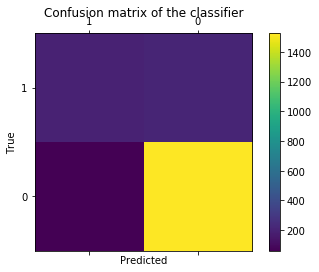

In [62]:
# Confusion matrix for  adaboosting
adaboost = AdaBoostClassifier(n_estimators = 250,learning_rate = 0.3)
adaboost.fit(X_train2,y_train)
y_pred = adaboost.predict(X_val2)

print("THIS IS THE CONFUSION MATRIX BELOW")
print("")
labels = [1, 0]
cm = confusion_matrix(y_val, y_pred, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [63]:
#Find AUROC for gradient boosting
prob_adaboost = adaboost.predict_proba(X_val2)[:,1]
auroc = roc_auc_score(y_val,prob_adaboost)
print('ADABoost AUROC score =', auroc)

ADABoost AUROC score = 0.8712160395220854


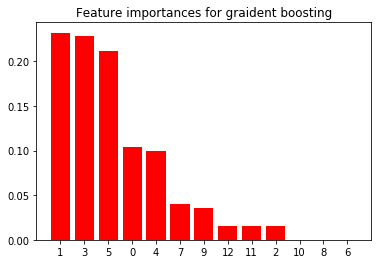

1. feature 1 (0.232000)
2. feature 3 (0.228000)
3. feature 5 (0.212000)
4. feature 0 (0.104000)
5. feature 4 (0.100000)
6. feature 7 (0.040000)
7. feature 9 (0.036000)
8. feature 12 (0.016000)
9. feature 11 (0.016000)
10. feature 2 (0.016000)
11. feature 10 (0.000000)
12. feature 8 (0.000000)
13. feature 6 (0.000000)


In [84]:
# Plot the Feature importance for adaboost
importances = adaboost.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances for graident boosting")
plt.bar(range(X_train2.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X_train2.shape[1]), indices)
plt.xlim([-1, X_train2.shape[1]])
plt.show()

for f in range(X_train2.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

### Conclusions

Random Forest tackles the error reduction task by reducing variance. Therefore Random Forest is harder to overfit than Gradient Booting decision trees.

Boosting reduces error mainly by reducing bias. Boosting uses weak learners (high bias, low variance). Each weak classifier is trained to improve the already trained ensemble. Therefore Gradient boosting is more effective with large datasets with high dimensions.